In [25]:
# Cella 1: Reset, Clone e Configurazione Ambiente

import os
import sys

# 1. --- RESET AMBIENTE ---
# Torna alla directory di base e rimuovi il repository
print("Esecuzione Reset Ambiente...")
try:
    os.chdir('/content/')
    !rm -rf Hawk-AI-CV-Project
except:
    pass

# 2. --- CLONAZIONE ---
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# 3. --- CAMBIO DIRECTORY (CD) E PATH ---
repo_name = "Hawk-AI-CV-Project"
%cd $repo_name

# Aggiungi la radice del repo al PATH di Python
sys.path.insert(0, os.getcwd())

# 4. --- INSTALLAZIONE LIBRERIE ---
print("Installazione librerie necessarie...")
!pip install numpy opencv-python matplotlib

print("\nSetup completato. Ora la tua root è:")
print(os.getcwd())

Esecuzione Reset Ambiente...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 456 (delta 25), reused 0 (delta 0), pack-reused 387 (from 2)
Receiving objects: 100% (456/456), 11.04 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/Hawk-AI-CV-Project
Installazione librerie necessarie...

Setup completato. Ora la tua root è:
/content/Hawk-AI-CV-Project


In [26]:
# Cella 1.5: Pulizia Cache Moduli

import importlib
import sys

# Rimuove i moduli specifici dalla cache di Python, forzando un reload completo in Cella 2
if 'src.config' in sys.modules:
    del sys.modules['src.config']
if 'src.court_features' in sys.modules:
    del sys.modules['src.court_features']

print("Cache dei moduli 'config' e 'court_features' eliminata. La Cella 2 caricherà i file freschi.")

Cache dei moduli 'config' e 'court_features' eliminata. La Cella 2 caricherà i file freschi.


In [27]:
# Cella 2: Caricamento delle Immagini Originali

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from src import config

# Dizionario per accumulare le immagini caricate (originali)
immagini_caricate = {}

print("========================================================")
print("== CARICAMENTO DELLE IMMAGINI STATICH CON FRAME_PATH ==")
print("========================================================")

for superficie, params in config.ALL_SURFACE_PARAMS.items():
    image_path = params['FRAME_PATH']
    # Carica l'immagine in formato BGR (default di OpenCV)
    bgr_image = cv.imread(image_path)

    if bgr_image is not None:
        # Converti in RGB per la visualizzazione con Matplotlib
        rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

        immagini_caricate[superficie] = {
            'bgr': bgr_image,  # Originale BGR (per essere passata a trova_linee)
            'rgb': rgb_image,  # Originale RGB
            'path': image_path,
        }
        print(f"✅ Caricato: {superficie} ({bgr_image.shape[1]}x{bgr_image.shape[0]})")
    else:
        print(f"❌ ERRORE: Impossibile caricare l'immagine per {superficie} da {image_path}")

print("========================================================")


== CARICAMENTO DELLE IMMAGINI STATICH CON FRAME_PATH ==
✅ Caricato: CEMENTO (1075x613)
✅ Caricato: ERBA (1068x609)
✅ Caricato: TERRA_BATTUTA (1069x601)



== TEST SUPERFICIE: CEMENTO ==
 	 Parametri CANNY usati: LOW=25, HIGH=70
 	 Soglia HOUGH usata: 40

✅ OUTPUT M3 (PRIME 5 LINEE per CEMENTO):
[[381 403 604 403]
 [606 402 782 402]
 [358 198 427 200]
 [380 401 605 401]
 [607 404 781 404]]
Forma dell'array: (51, 4)


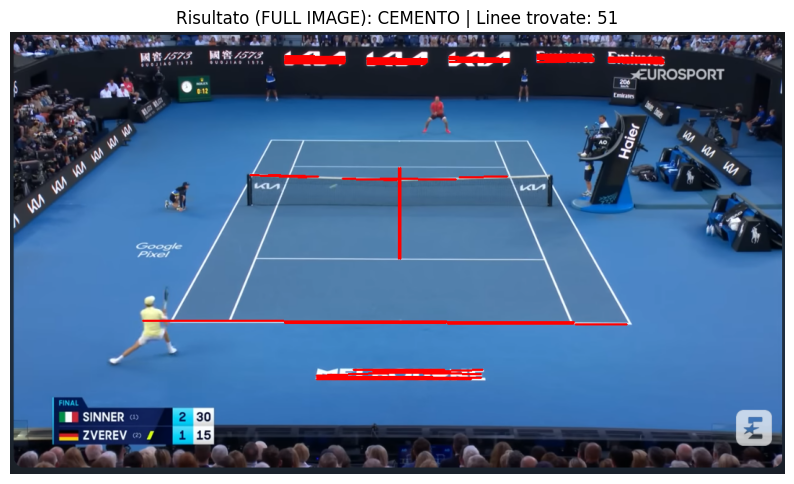


== TEST SUPERFICIE: ERBA ==
 	 Parametri CANNY usati: LOW=30, HIGH=100
 	 Soglia HOUGH usata: 50


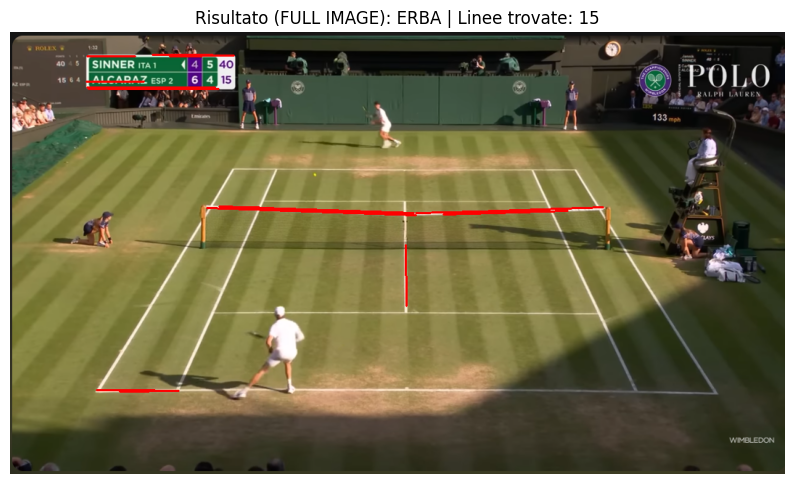


== TEST SUPERFICIE: TERRA_BATTUTA ==
 	 Parametri CANNY usati: LOW=40, HIGH=120
 	 Soglia HOUGH usata: 40


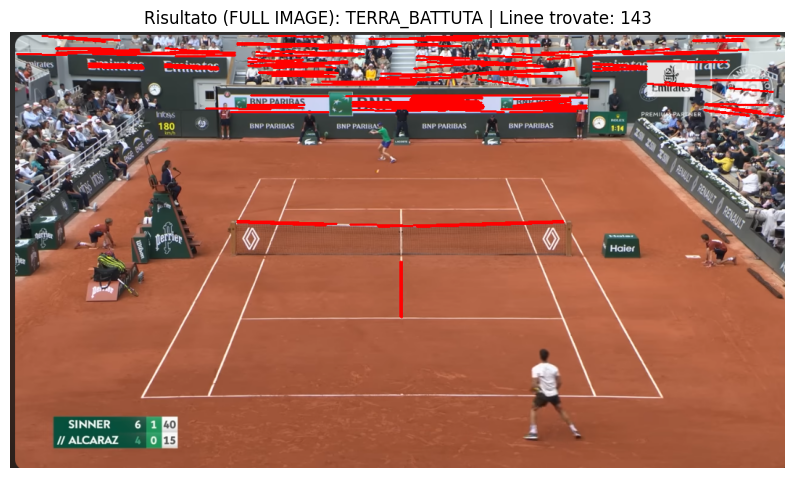


======================= RIEPILOGO COMPLETO =======================

SUPERFICIE: CEMENTO
 	-> Linee Trovate: 51
 	-> Canny/Hough Usati: 70/40

SUPERFICIE: ERBA
 	-> Linee Trovate: 15
 	-> Canny/Hough Usati: 100/50

SUPERFICIE: TERRA_BATTUTA
 	-> Linee Trovate: 143
 	-> Canny/Hough Usati: 120/40


In [28]:
# Cella 3: Esecuzione del Loop di Tuning e Visualizzazione dei Risultati

from src.court_features import trova_linee # Importa la funzione
import cv2 as cv # Importa cv2 per le conversioni
import matplotlib.pyplot as plt
import numpy as np

# Assicurati che immagini_caricate esista dalla Cella 2
risultati_finali = {}

# --- 1. LOOP DI TUNING PER OGNI SUPERFICIE ---
for superficie, dati_immagine in immagini_caricate.items():

    params = config.ALL_SURFACE_PARAMS[superficie]

    print(f"\n========================================================")
    print(f"== TEST SUPERFICIE: {superficie} ==")
    print(f" 	 Parametri CANNY usati: LOW={params['CANNY_LOW']}, HIGH={params['CANNY_HIGH']}")
    print(f" 	 Soglia HOUGH usata: {params['HOUGH_THRESHOLD']}")
    print(f"========================================================")

    # Chiama trova_linee sull'immagine originale (bgr)
    raw_line_segments = trova_linee(dati_immagine['bgr'], superficie)

    # --- AGGIUNGI QUI LA STAMPA PER IL MEMBRO 3 ---
    if superficie == 'CEMENTO':
        print(f"\n✅ OUTPUT M3 (PRIME 5 LINEE per {superficie}):")
        print(raw_line_segments[:5])
        print(f"Forma dell'array: {raw_line_segments.shape}")
    # -----------------------------------------------

    # --- 2. VISUALIZZAZIONE DEI RISULTATI ---
    # Usiamo l'immagine *originale* per disegnare le linee
    line_frame_rgb = np.copy(dati_immagine['rgb'])

    linee_trovate = len(raw_line_segments)

    if linee_trovate > 0:
        # Lavoriamo in BGR per cv.line
        line_frame_bgr = cv.cvtColor(line_frame_rgb, cv.COLOR_RGB2BGR)

        # Disegniamo le linee trovate (coordinate relative al frame originale)
        for x1, y1, x2, y2 in raw_line_segments:
            cv.line(line_frame_bgr, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # Riconvertiamo in RGB per la visualizzazione
        line_frame_rgb = cv.cvtColor(line_frame_bgr, cv.COLOR_BGR2RGB)


    # Visualizza il risultato con matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(line_frame_rgb)
    plt.title(f"Risultato (FULL IMAGE): {superficie} | Linee trovate: {linee_trovate}")
    plt.axis('off')
    plt.show()

    # 3. Registra i risultati
    risultati_finali[superficie] = {
        'Canny Low': params['CANNY_LOW'],
        'Canny High': params['CANNY_HIGH'],
        'Hough Threshold': params['HOUGH_THRESHOLD'],
        'Totale Linee Trovate': linee_trovate,
        'Raw Segments': raw_line_segments, # Linee (coordinate originali)
        'Original Image': dati_immagine['rgb'] # Salviamo l'immagine originale RGB per Cella 4
    }

# --- RIEPILOGO FINALE ---
print("\n======================= RIEPILOGO COMPLETO =======================")
for superficie, params in risultati_finali.items():
    print(f"\nSUPERFICIE: {superficie}")
    print(f" 	-> Linee Trovate: {params['Totale Linee Trovate']}")
    print(f" 	-> Canny/Hough Usati: {params['Canny High']}/{params['Hough Threshold']}")

🏁 INIZIO CALCOLO OMOGRAFIA (MATRICE H) PER TUTTI I CAMPI

--- 🗺️ CALCOLO PER SUPERFICIE: CEMENTO ---
Input: 51 segmenti di linea filtrati.

Matrice di Omografia H calcolata con successo per CEMENTO.

✅ Matrice H calcolata con successo per CEMENTO.
Matrice H (3x3):
[[ 4.11499977e+00  0.00000000e+00 -2.21798488e+03]
 [ 0.00000000e+00 -3.20000005e+00  1.53920002e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


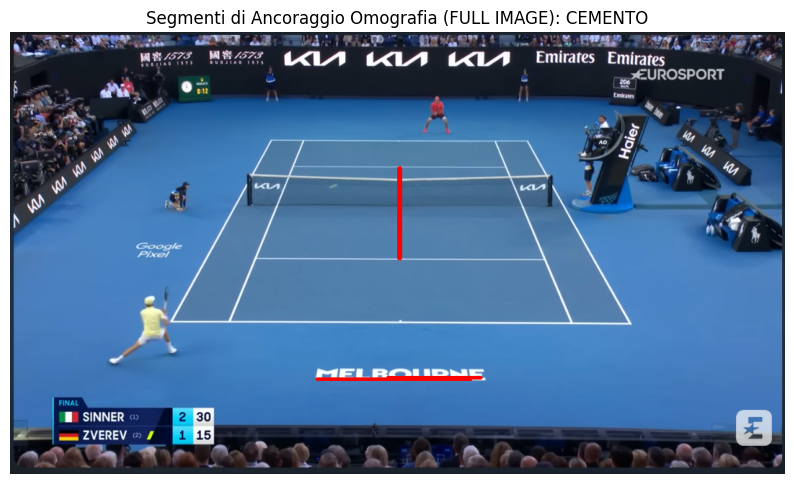


--- ESEMPIO DI MAPPATURA (TEST) ---
Punto Pixel di Input (rispetto all'originale): (100, 500) (u, v)
Posizione Reale (Metri): X=-1806.485, Y=-60.800

--- 🗺️ CALCOLO PER SUPERFICIE: ERBA ---
Input: 15 segmenti di linea filtrati.
Errore: Non sono stati trovati abbastanza segmenti Orizzontali o Verticali (minimo 2 ciascuno).
❌ Errore critico nel calcolo Omografia per ERBA. Controlla i log.

--- 🗺️ CALCOLO PER SUPERFICIE: TERRA_BATTUTA ---
Input: 143 segmenti di linea filtrati.

Matrice di Omografia H calcolata con successo per TERRA_BATTUTA.

✅ Matrice H calcolata con successo per TERRA_BATTUTA.
Matrice H (3x3):
[[ 4.35156776e-01  6.73363994e-18 -2.34114345e+02]
 [-6.93692798e-03 -2.63699833e-01  7.45632282e+01]
 [-1.65602052e-03  1.67329773e-18  1.00000000e+00]]


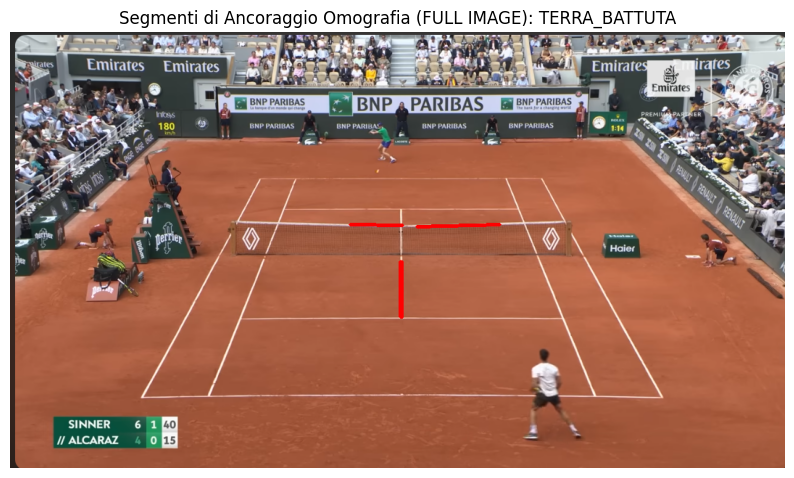


--- ESEMPIO DI MAPPATURA (TEST) ---
Punto Pixel di Input (rispetto all'originale): (100, 500) (u, v)
Posizione Reale (Metri): X=-228.427, Y=-69.488

✨ CONSEGNA M3 COMPLETATA: 2 Matrici H generate.


In [29]:
# Cella 4: Esecuzione del Calcolo Omografia (M3) e Visualizzazione (su Immagine Originale)

from src import homography_calculator
import matplotlib.pyplot as plt
import cv2 as cv

# Dizionario per salvare le tre Matrici H
homography_matrices = {}

# Punti di test (coordinate rispetto all'immagine originale).
test_pixel_coords = (100, 500)

print("======================================================")
print("🏁 INIZIO CALCOLO OMOGRAFIA (MATRICE H) PER TUTTI I CAMPI")
print("======================================================")

# Cicla attraverso tutti i risultati del tuning
for superficie, risultati in risultati_finali.items():

    # --- RECUPERO DATI DALLA CELLA 3 ---
    line_segments_m1 = risultati['Raw Segments']

    # Ottieni l'immagine originale in RGB
    original_image_rgb = risultati['Original Image'].copy()

    # Conversione in BGR per le funzioni OpenCV (cv.line, findHomography)
    original_image_bgr = cv.cvtColor(original_image_rgb, cv.COLOR_RGB2BGR)

    print(f"\n--- 🗺️ CALCOLO PER SUPERFICIE: {superficie} ---")

    if line_segments_m1.size == 0:
        print("❌ Nessun segmento valido trovato. Omografia saltata.")
        continue

    print(f"Input: {line_segments_m1.shape[0]} segmenti di linea filtrati.")

    # 1. CALCOLA LA MATRICE DI OMOGRAFIA (H) - Usa le coordinate relative all'immagine originale
    H_matrix, selected_lines = homography_calculator.calculate_homography(line_segments_m1, superficie)

    if H_matrix is not None:
        # Salva la Matrice H
        homography_matrices[superficie] = H_matrix

        print(f"\n✅ Matrice H calcolata con successo per {superficie}.")
        print("Matrice H (3x3):")
        print(H_matrix)

        # 2. VISUALIZZAZIONE DEI 4 SEGMENTI DI ANCORAGGIO

        img_display = original_image_bgr.copy() # Lavoriamo su una copia BGR

        # Disegna i 4 segmenti selezionati in ROSSO su img_display
        for x1, y1, x2, y2 in selected_lines:
            cv.line(img_display, (x1, y1), (x2, y2), (0, 0, 255), 4) # Colore BGR: (0, 0, 255) è rosso

        # Visualizza l'immagine (convertendo BGR in RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv.cvtColor(img_display, cv.COLOR_BGR2RGB))
        plt.title(f"Segmenti di Ancoraggio Omografia (FULL IMAGE): {superficie}")
        plt.axis('off')
        plt.show()

        # 3. ESEGUE UN TEST DI MAPPATURA (VERIFICA)
        world_coords = homography_calculator.map_pixel_to_world(H_matrix, test_pixel_coords)

        print("\n--- ESEMPIO DI MAPPATURA (TEST) ---")
        print(f"Punto Pixel di Input (rispetto all'originale): {test_pixel_coords} (u, v)")
        print(f"Posizione Reale (Metri): X={world_coords[0]:.3f}, Y={world_coords[1]:.3f}")

    else:
        print(f"❌ Errore critico nel calcolo Omografia per {superficie}. Controlla i log.")

print("\n======================================================")
print(f"✨ CONSEGNA M3 COMPLETATA: {len(homography_matrices)} Matrici H generate.")
print("======================================================")